# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

P = matrix(np.array([[2.0, 0.0],
                     [0.0, 8.0]]))

q = matrix(np.array([-8.0, -16.0]))

G = matrix(np.array([[-1.0, 0.0], 
                     [1.0, 0.0], 
                     [0.0, -1.0], 
                     [1.0, 1.0]]))

h = matrix(np.array([0.0, 3.0, 0.0, 5.0]))

sol = solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  1e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  2e-16  5e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  3e-17
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  4e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.


In [2]:
print(sol["x"])

[ 3.00e+00]
[ 2.00e+00]


In [4]:
G = matrix(np.array([[1.0, 0.0]]))

h = matrix(np.array([3.0]))

sol = solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0: -3.1889e+01 -3.1444e+01  7e-01  6e-01  1e-16
 1: -3.1639e+01 -3.1160e+01  1e-02  1e-01  1e-17
 2: -3.0992e+01 -3.1000e+01  8e-03  1e-16  4e-16
 3: -3.1000e+01 -3.1000e+01  8e-05  0e+00  2e-17
 4: -3.1000e+01 -3.1000e+01  8e-07  0e+00  5e-17
Optimal solution found.


In [5]:
print(sol["x"])

[ 3.00e+00]
[ 2.00e+00]


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

## 1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.

In [6]:
from numpy import sign


class SVM:
    def __init__(self, X, y, C):
        self.X = X
        self.y = y
        self.C = C
        self.w = 0
        self.bias = 0
        
        
    def fit(self):
        X = self.X #[2, M]
        y = self.y
        C = self.C
        
        n = X.shape[1]
        P = matrix(np.dot((X * y).T, X * y))
        q = matrix(-np.ones((n)))
        G = matrix(np.vstack((-(np.eye(n)), (np.eye(n)))))
        h = matrix(np.hstack((np.zeros(n), np.ones(n) * C)))
        A = matrix(y)
        b = matrix(0.0)
        
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol["x"])
        
        S = (alphas > 10 ** -5).reshape(-1)
        main_X = X.T[S].T
        
        w = np.dot(main_X, (alphas[S] * y.T[S]))
        
        bias = np.mean(y.T[S] - np.dot(np.dot(main_X.T, main_X), (alphas[S] * y.T[S])))
        
        
        self.w = w
        self.bias = bias
    
    
    def make_grahp(self, my_plt):
        X = self.X
        y = self.y
        w = self.w
        b = self.bias
        
        
        X1 = X[0]
        X2 = X[1]
        
        
        x_for_lines = np.linspace(X1.min(), X1.max(), 15)
        
        dividing_line_y = - self.bias / (w[1]) - (w[0] / w[1]) * x_for_lines
        
        level_lines1 = (-1 - b) / w[1] - (w[0] / w[1]) * x_for_lines
        
        level_lines2 = (1 - b) / w[1] - (w[0] / w[1]) * x_for_lines
        
        
        plt.scatter(X1, X2)
        
        
        my_plt.plot(x_for_lines, dividing_line_y, c="black")
        my_plt.plot(x_for_lines, level_lines1, "--", c="orange")
        my_plt.plot(x_for_lines, level_lines2, "--", c="orange")
        

        
        eps = 0.01
        
        index_inside = (X2 - eps <= (1 - b) / w[1] - (w[0] / w[1]) * X1) * (X2 + eps >= (-1 - b) / w[1] - (w[0] / w[1]) * X1)
        
        index_inside1 = index_inside * ((y == 1).reshape(-1))
        index_inside2 = index_inside * ((y == -1).reshape(-1))
        
        index_more = ((y == 1).reshape(-1)) 
        index_less = ((y == -1).reshape(-1)) 
        
        
        
        my_plt.scatter(X1[index_more], X2[index_more], c="red")
        my_plt.scatter(X1[index_less], X2[index_less], c="green")
        my_plt.scatter(X1[index_inside1], X2[index_inside1], c="lightcoral")
        my_plt.scatter(X1[index_inside2], X2[index_inside2], c="lime")
        
        my_plt.set_title(f"C = {self.C}. Кол-во опорных векторов = {sum(index_inside)}")
        my_plt.set_xlabel("X1")
        my_plt.set_ylabel("X2")
        
        
    def predict_proba(self, X):
        return (np.dot(self.w.T, X) + self.bias).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))
    

## 2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
## 3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.

## Эти два задания делаю вместе. Код расположен ниже

### Линейно-разделимые классы:

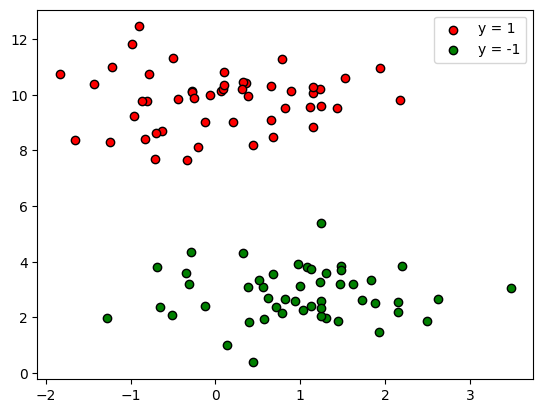

In [7]:
size = 50

data0 = np.random.multivariate_normal(mean=[0, 10], cov=[[1, 0], [0, 1]], size=size)
data1 = np.random.multivariate_normal(mean=[1, 3], cov=[[1, 0], [0, 1]], size=size)

X = np.vstack((data0, data1)).T

y = np.hstack(((np.ones(size)), (-np.ones(size)))).reshape(1, -1)

plt.scatter(data0[:, 0], data0[:, 1], c='red', edgecolor='k')
plt.scatter(data1[:, 0], data1[:, 1], c='green', edgecolor='k')
plt.legend(['y = 1', 'y = -1'])

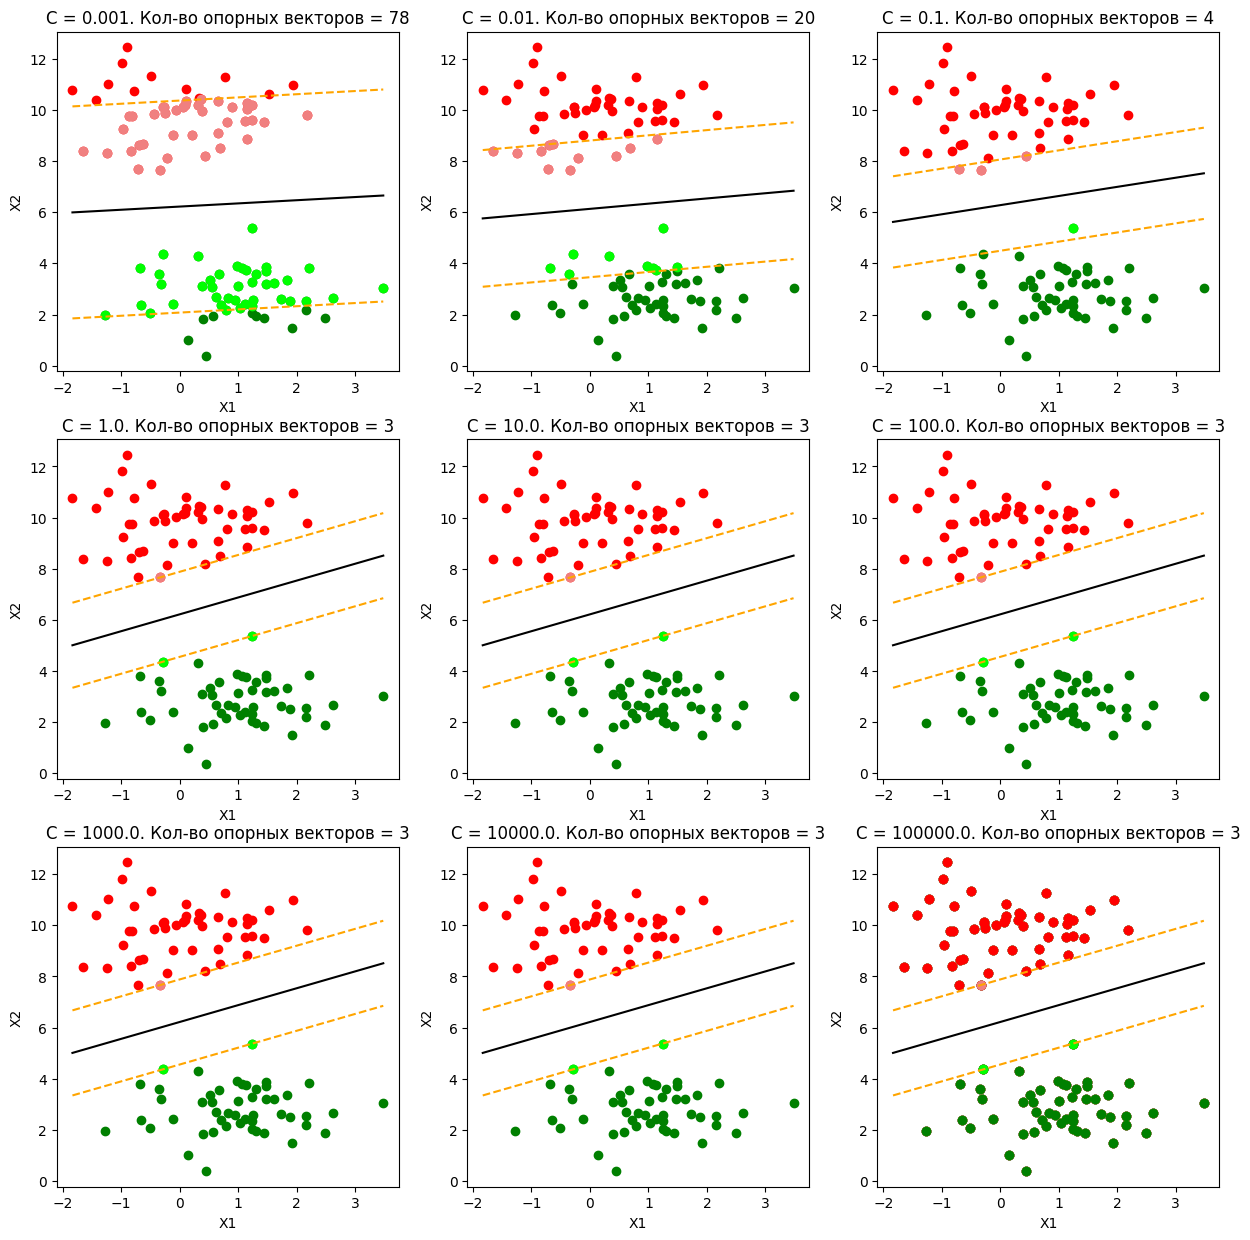

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
C_arr = np.logspace(-3, 5, 9)

for i, C in enumerate(C_arr):
    svm = SVM(X, y, C)
    svm.fit()
    svm.make_grahp(ax[i // 3][i % 3])

### Хорошо разделимые классы (не линейно):

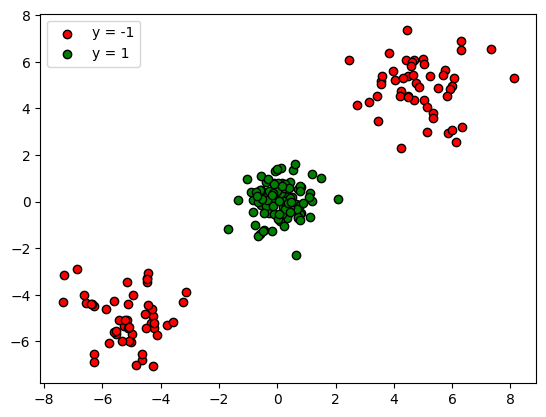

In [9]:
size = 50

data01 = np.random.multivariate_normal(mean=[-5, -5], cov=[[1, 0], [0, 1]], size=size)
data02 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, 0], [0, 1]], size=size)

data1 = np.random.multivariate_normal(mean=[0, 0], cov=[[0.5, 0], [0, 0.5]], size=size * 2)

data0 = np.vstack((data01, data02))

X = np.vstack((data0, data1)).T

y = np.hstack((-np.ones(100), np.ones(100))).reshape(1, -1)

plt.scatter(data0[:, 0], data0[:, 1], c='red', edgecolor='k')
plt.scatter(data1[:, 0], data1[:, 1], c='green', edgecolor='k')
plt.legend(['y = -1', 'y = 1'])

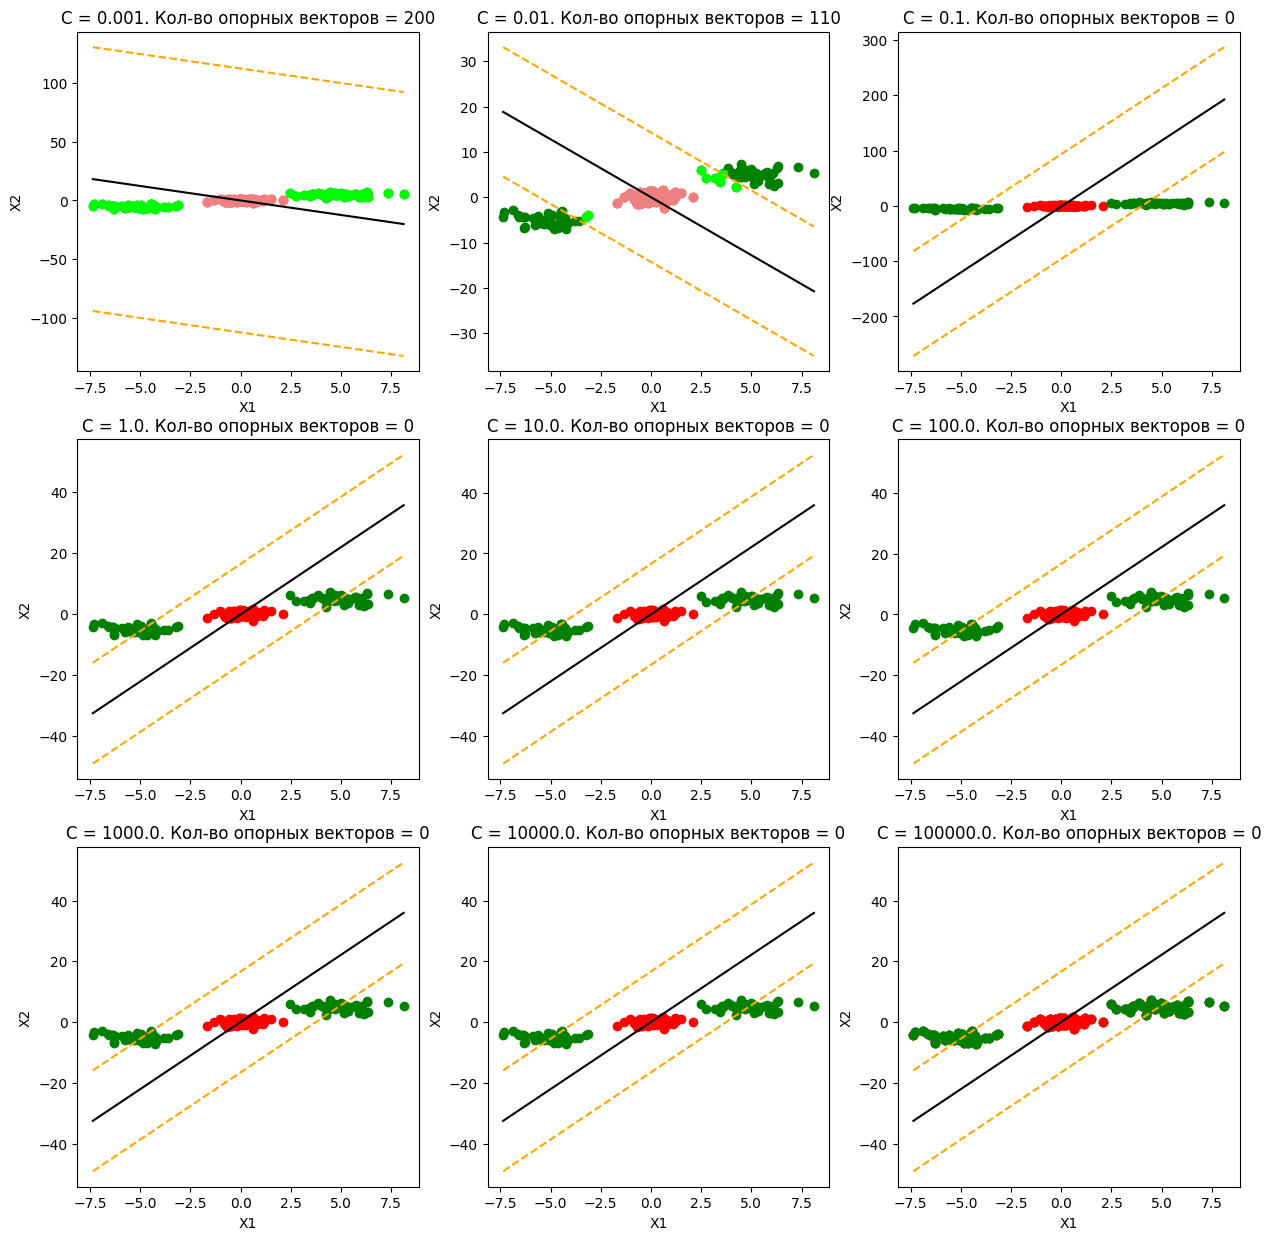

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
C_arr = np.logspace(-3, 5, 9)

for i, C in enumerate(C_arr):
    svm = SVM(X, y, C)
    svm.fit()
    svm.make_grahp(ax[i // 3][i % 3])

### Плохо разделимые классы по имеющимся признакам:

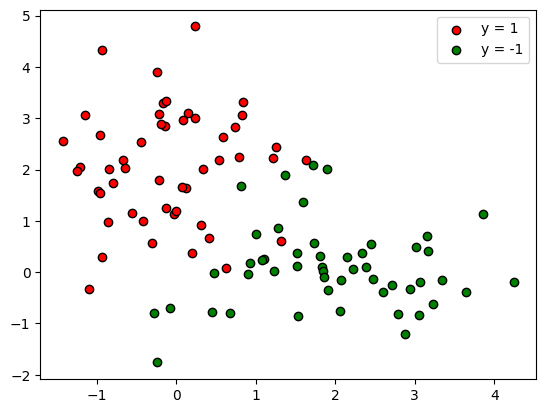

In [11]:
size = 50

data0 = np.random.multivariate_normal(mean=[0, 2], cov=[[1, 0], [0, 1]], size=size)
data1 = np.random.multivariate_normal(mean=[2, 0], cov=[[1, 0], [0, 1]], size=size)

X = np.vstack((data0, data1)).T

y = np.hstack(((np.ones(size)), (-np.ones(size)))).reshape(1, -1)

plt.scatter(data0[:, 0], data0[:, 1], c='red', edgecolor='k')
plt.scatter(data1[:, 0], data1[:, 1], c='green', edgecolor='k')
plt.legend(['y = 1', 'y = -1'])

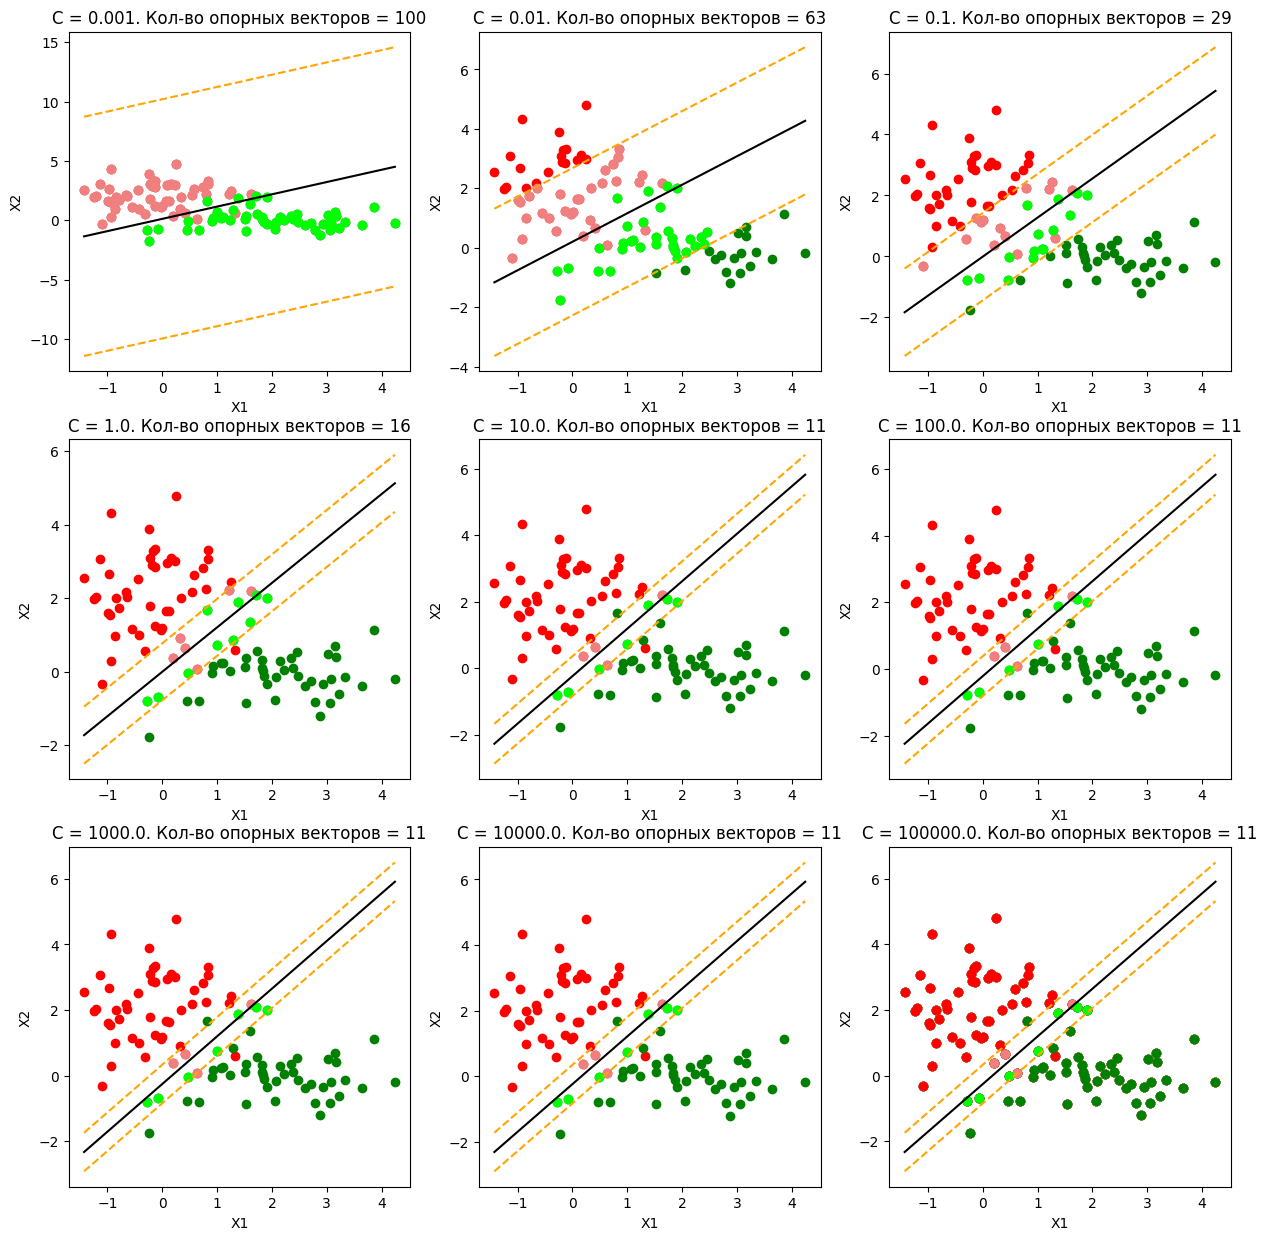

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
C_arr = np.logspace(-3, 5, 9)

for i, C in enumerate(C_arr):
    svm = SVM(X, y, C)
    svm.fit()
    svm.make_grahp(ax[i // 3][i % 3])

## 5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

Text(0, 0.5, 'X2')

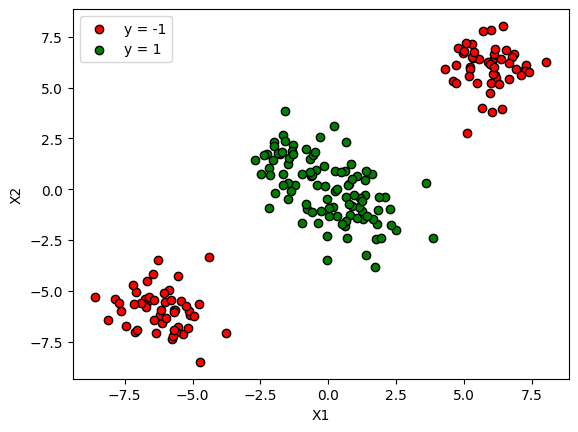

In [13]:
size = 50

data_minus_01 = np.random.multivariate_normal(mean=[-6, -6], cov=[[1, 0], [0, 1]], size=size)
data_minus_02 = np.random.multivariate_normal(mean=[6, 6], cov=[[1, 0], [0, 1]], size=size)

data_minus = np.vstack((data_minus_01, data_minus_02))


data_plus_01 = np.random.multivariate_normal(mean=[1, -1], cov=[[1, 0], [0, 1]], size=size)
data_plus_02 = np.random.multivariate_normal(mean=[-1, 1], cov=[[1, 0], [0, 1]], size=size)

data_plus = np.vstack((data_plus_01, data_plus_02))


plt.scatter(data_minus.T[0], data_minus.T[1], c='red', edgecolor='k')
plt.scatter(data_plus.T[0], data_plus.T[1], c='green', edgecolor='k')
plt.legend(['y = -1', 'y = 1'])
plt.xlabel("X1")
plt.ylabel("X2")

### Из графика видно, что данные линейно не разделимы. Заменим x2 на x1^2 + x2^2

Text(0, 0.5, 'X1^2 + X2^2')

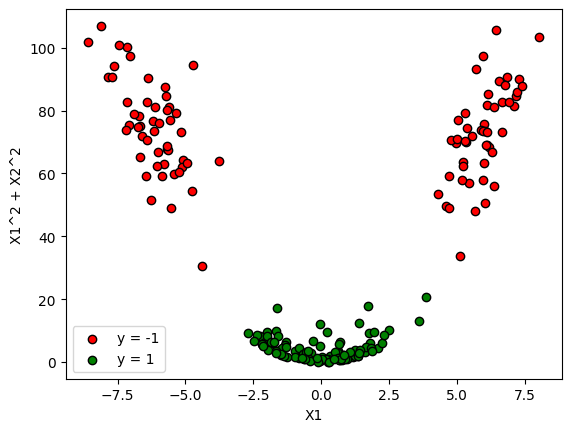

In [14]:
data_minus_3 = np.hstack((data_minus, (data_minus.T[0] ** 2 + data_minus.T[1] ** 2).reshape(-1, 1)))
data_plus_3 = np.hstack((data_plus, (data_plus.T[0] ** 2 + data_plus.T[1] ** 2).reshape(-1, 1)))

data = np.vstack((data_minus_3, data_plus_3))

X = np.vstack((data.T[0], data.T[2]))
y = np.hstack(((np.ones(size * 2)), (-np.ones(size * 2)))).reshape(1, -1)


plt.scatter(data_minus_3.T[0], data_minus_3.T[2], c='red', edgecolor='k')
plt.scatter(data_plus_3.T[0], data_plus_3.T[2], c='green', edgecolor='k')
plt.legend(['y = -1', 'y = 1'])
plt.xlabel("X1")
plt.ylabel("X1^2 + X2^2")

### Теперь данные линейно разделимы. Можем Обучать модель.

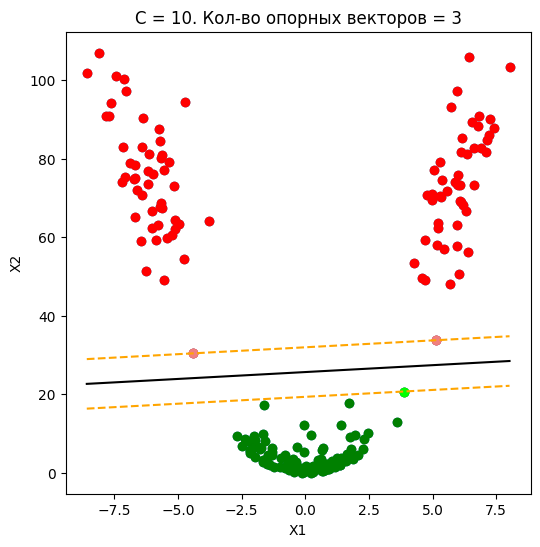

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

svm = SVM(X, y, C=10)
svm.fit()
svm.make_grahp(ax)

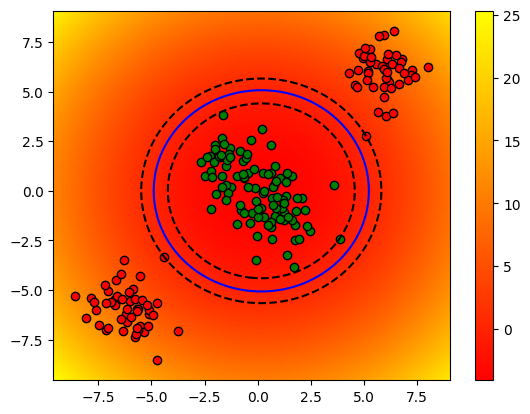

In [16]:
def transform_data(X, Y):
    data = [X.ravel(), Y.ravel()]
    data = [data[0], data[0] ** 2 + data[1] ** 2]
    return data


X = np.vstack((data.T[0], data.T[1]))


xvals = np.linspace(X[0].min() - 1, X[0].max() + 1, 200)
yvals = np.linspace(X[1].min() - 1, X[1].max() + 1, 200)

xx, yy = np.meshgrid(xvals, yvals)


zz = svm.predict_proba(transform_data(xx, yy))
zz = zz.reshape(xx.shape)

c = plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

plt.colorbar(c)

plt.contour(xx, yy, zz, levels=(1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
plt.contour(xx, yy, zz, levels=(0.0,), colors='b', linewidths=1.5)
plt.contour(xx, yy, zz, levels=(-1.0,), colors='k', linewidths=1.5)

plt.scatter(data_minus.T[0], data_minus.T[1], c='red', edgecolor='k')
plt.scatter(data_plus.T[0], data_plus.T[1], c='green', edgecolor='k')

### Разделили данные. На Графике видно опорные вектора и азделяющую гиперплоскость

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

###  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.

In [17]:
class SVM_KERNEL:
    def __init__(self, X, y, C, kernel_function, p=0, sigm=0):
        self.X = X
        self.y = y
        self.C = C
        self.kernel_function = kernel_function
        self.p = p
        self.sigm = sigm
        
        self.S = 0
        self.main_X = 0
        self.alphas = 0
        
        
    def kernel(self, X1, X2):
        if self.kernel_function == "linear":
            return np.dot(X1.T, X2)
        
        if self.kernel_function == "poly":
            return (np.dot(X1.T, X2) + 1) ** self.p
        
        if self.kernel_function == "gauss":
            norm1 = np.linalg.norm(X1, axis=0) ** 2 
            norm2 = np.linalg.norm(X2, axis=0) ** 2
            
            x = ((-2 * np.dot(X1.T, X2) + norm2).T + norm1).T / -(self.sigm ** 2 * 2)
            return np.exp(x)
            
            
    def fit(self):
        X = self.X
        y = self.y
        C = self.C
        
        n = X.shape[1]
        P = matrix(self.kernel(X * y, X * y))
        q = matrix(-np.ones((n)))
        G = matrix(np.vstack((-(np.eye(n)), (np.eye(n)))))
        h = matrix(np.hstack((np.zeros(n), np.ones(n) * C)))
        A = matrix(y)
        b = matrix(0.0)
        solvers.options['show_progress'] = False
        
        sol = solvers.qp(P, q, G, h, A, b)
        
        alphas = np.array(sol["x"])
        
        S = (alphas > 10 ** -5).flatten()
        
        main_X = (X.T[S]).T
        
        bias = np.mean(y.T[S] - np.dot(self.kernel(main_X, main_X), (alphas[S] * y.T[S])))
        
        self.bias = bias
        self.S = S
        self.main_X = main_X
        self.alphas = alphas
        
        
    def make_grahp(self, my_plt, fig):
        fig.tight_layout(h_pad=2)
        X = self.X
        y = self.y
        main_X = self.main_X
        
        
        xvals = np.linspace(X[0].min() - 1, X[0].max() + 1, 200)
        yvals = np.linspace(X[1].min() - 1, X[1].max() + 1, 200)

        xx, yy = np.meshgrid(xvals, yvals)


        zz = self.predict_proba(np.array([xx.ravel(), yy.ravel()]))
        zz = zz.reshape(xx.shape)

        c = my_plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

        fig.colorbar(c)

        my_plt.contour(xx, yy, zz, levels=(1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        my_plt.contour(xx, yy, zz, levels=(0.0,), colors='b', linewidths=1.5)
        my_plt.contour(xx, yy, zz, levels=(-1.0,), colors='k', linewidths=1.5)

        
        class1_index = (y == -1).reshape(-1)
        class2_index = (y == +1).reshape(-1)
        
        
        my_plt.scatter(X[0][class1_index] , X[1][class1_index], c='red', edgecolor='k')
        my_plt.scatter(X[0][class2_index] , X[1][class2_index], c='green', edgecolor='k')
        
        my_plt.scatter(X[0][(self.S * class1_index)], X[1][(self.S * class1_index)], c='lightcoral', edgecolor='k')
        my_plt.scatter(X[0][(self.S * class2_index)], X[1][(self.S * class2_index)], c='lime', edgecolor='k')
        
        if self.kernel_function == "linear":
            title = f"C = {self.C}. Kernel = {self.kernel_function}. \n"
            title += f"Кол-во опорных векторов = {sum(self.S)}"
            my_plt.set_title(title)
        if self.kernel_function == "poly":
            title = f"C = {self.C}. Kernel = {self.kernel_function}. \n"
            title += f"P = {self.p}. Кол-во опорных векторов = {sum(self.S)}"
            my_plt.set_title(title)
        
        if self.kernel_function == "gauss":
            title = f"C = {self.C}. Kernel = {self.kernel_function}. \n"
            title += f"Sigma = {self.sigm}. Кол-во опорных векторов = {sum(self.S)}"
            my_plt.set_title(title)
        
        my_plt.set_xlabel("X1")
        my_plt.set_ylabel("X2")
        
        
    def predict_proba(self, X):
        return (np.dot((self.alphas[self.S] * self.y.T[self.S]).T, self.kernel(self.main_X, X)) + self.bias).flatten()
    
    def predict(self, X):
        return sign(self.predict_proba(X))
    

### 2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
#### - линейная: $k(x, x') = x^Tx'$
#### - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
#### - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$

### Линейно разделимая выборка:

Text(0, 0.5, 'X2')

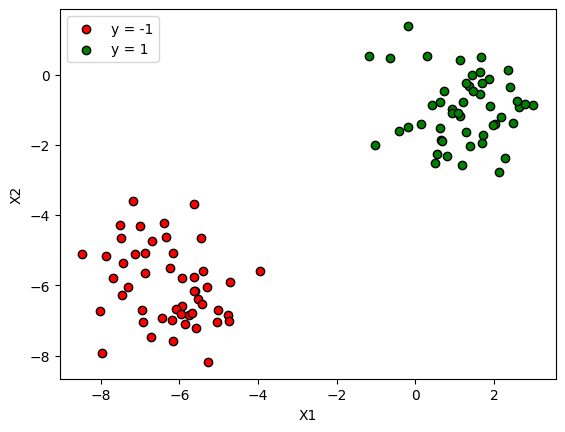

In [18]:
size = 50

data_minus = np.random.multivariate_normal(mean=[-6, -6], cov=[[1, 0], [0, 1]], size=size)

data_plus = np.random.multivariate_normal(mean=[1, -1], cov=[[1, 0], [0, 1]], size=size)
      
X_linear = np.vstack((data_minus, data_plus)).T
y_linear = np.hstack(((-np.ones(size)), (np.ones(size)))).reshape(1, -1)


plt.scatter(data_minus.T[0], data_minus.T[1], c='red', edgecolor='k')
plt.scatter(data_plus.T[0], data_plus.T[1], c='green', edgecolor='k')
plt.legend(['y = -1', 'y = 1'])
plt.xlabel("X1")
plt.ylabel("X2")

### Линейно неразделимая выборка:

Text(0, 0.5, 'X2')

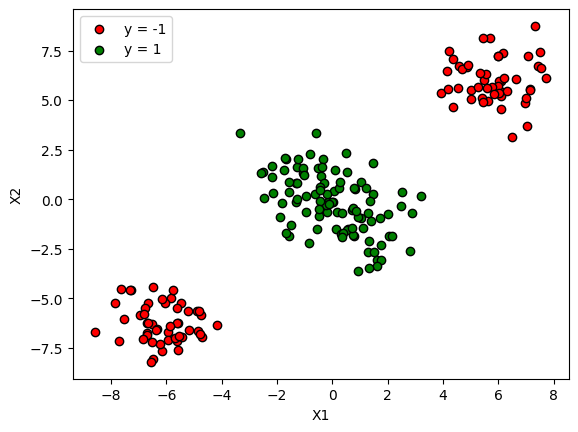

In [19]:
size = 50

data_minus_01 = np.random.multivariate_normal(mean=[-6, -6], cov=[[1, 0], [0, 1]], size=size)
data_minus_02 = np.random.multivariate_normal(mean=[6, 6], cov=[[1, 0], [0, 1]], size=size)

data_minus = np.vstack((data_minus_01, data_minus_02))


data_plus_01 = np.random.multivariate_normal(mean=[1, -1], cov=[[1, 0], [0, 1]], size=size)
data_plus_02 = np.random.multivariate_normal(mean=[-1, 1], cov=[[1, 0], [0, 1]], size=size)

data_plus = np.vstack((data_plus_01, data_plus_02))

X_notLinear = np.vstack((data_minus, data_plus)).T
y_notLinear = np.hstack(((-np.ones(size * 2)), (np.ones(size * 2)))).reshape(1, -1)


plt.scatter(data_minus.T[0], data_minus.T[1], c='red', edgecolor='k')
plt.scatter(data_plus.T[0], data_plus.T[1], c='green', edgecolor='k')
plt.legend(['y = -1', 'y = 1'])
plt.xlabel("X1")
plt.ylabel("X2")

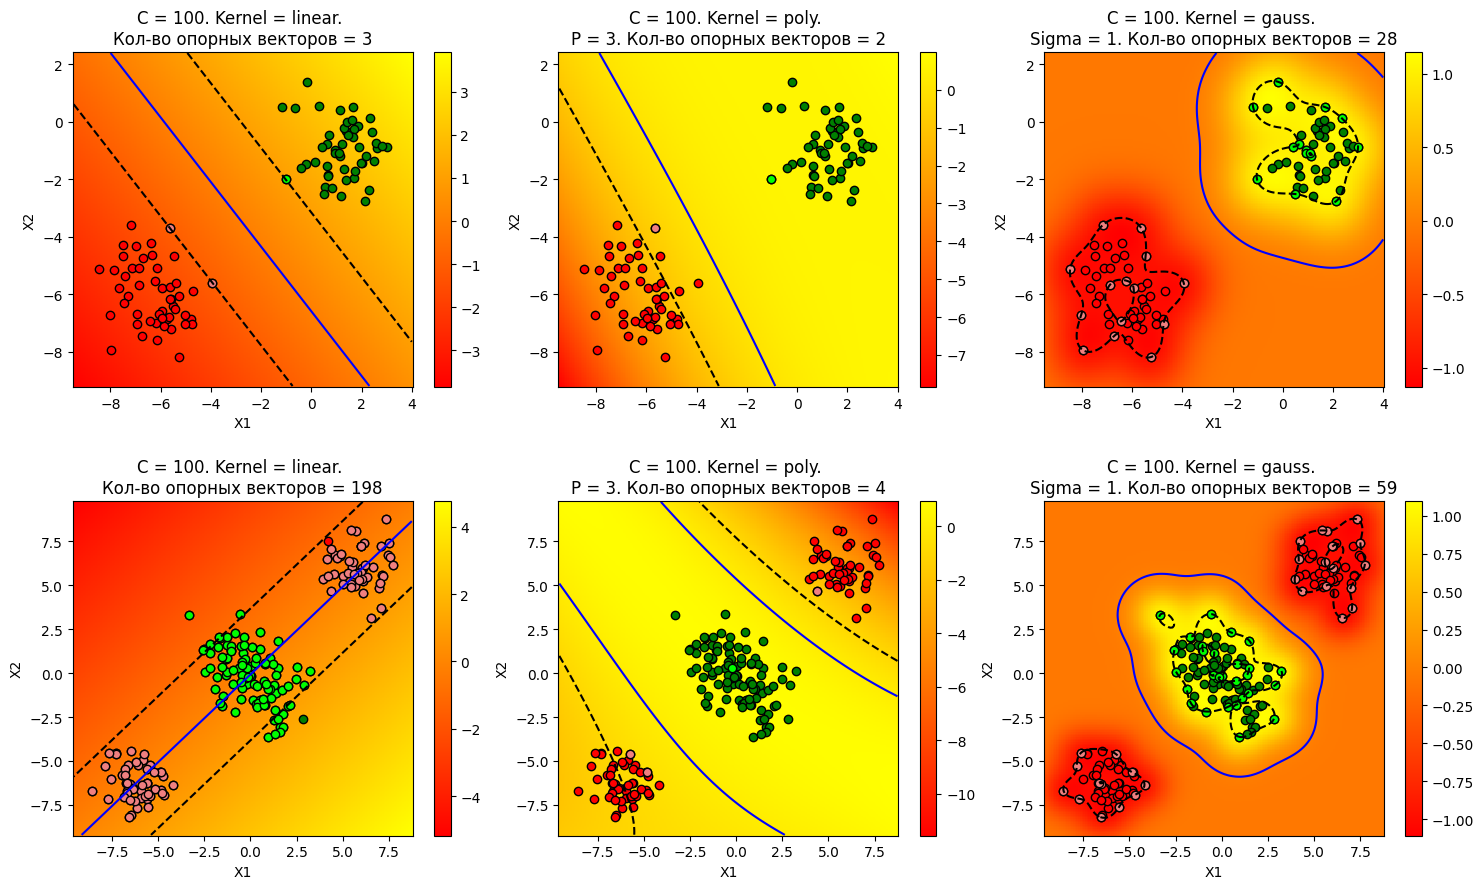

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

kernel_arr = ["linear", "poly", "gauss"]
my_C = 100

for j in range(3):
    svm = SVM_KERNEL(X=X_linear, y=y_linear, C=my_C, kernel_function=kernel_arr[j], p=3, sigm=1)
    svm.fit()
    svm.make_grahp(ax[0][j], fig)
    
    svm = SVM_KERNEL(X=X_notLinear, y=y_notLinear, C=my_C, kernel_function=kernel_arr[j], p=3, sigm=1)
    svm.fit()
    svm.make_grahp(ax[1][j], fig)

### 3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?

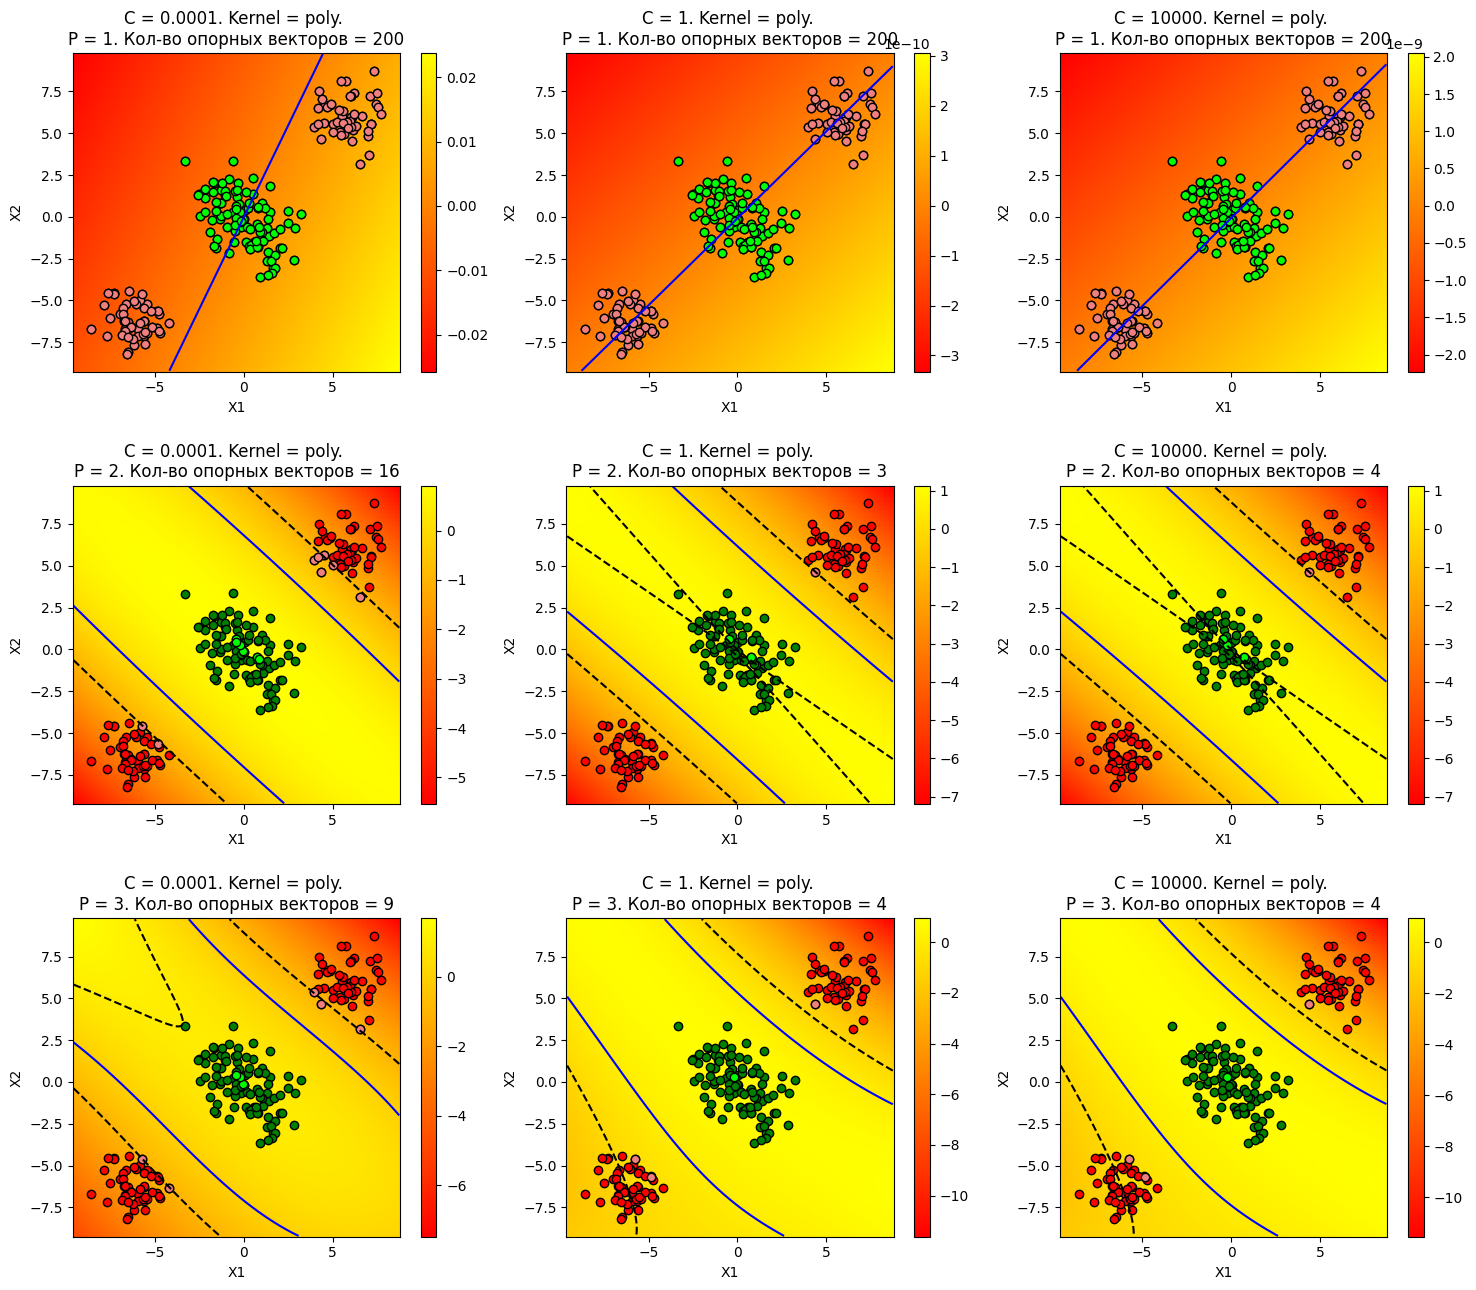

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(15, 13))

C_arr = [0.0001, 1, 10000]
p_arr = [1, 2, 3]


for i in range(3):
    for j in range(3):
        svm = SVM_KERNEL(X=X_notLinear, y=y_notLinear, C=C_arr[j], kernel_function="poly", p=p_arr[i])
        svm.fit()
        svm.make_grahp(ax[i][j], fig)

### P влияет на описание гиперплоскости, чем больше тем лучше, С на опорные векторы чем больше, тем меньше векторов

### 4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

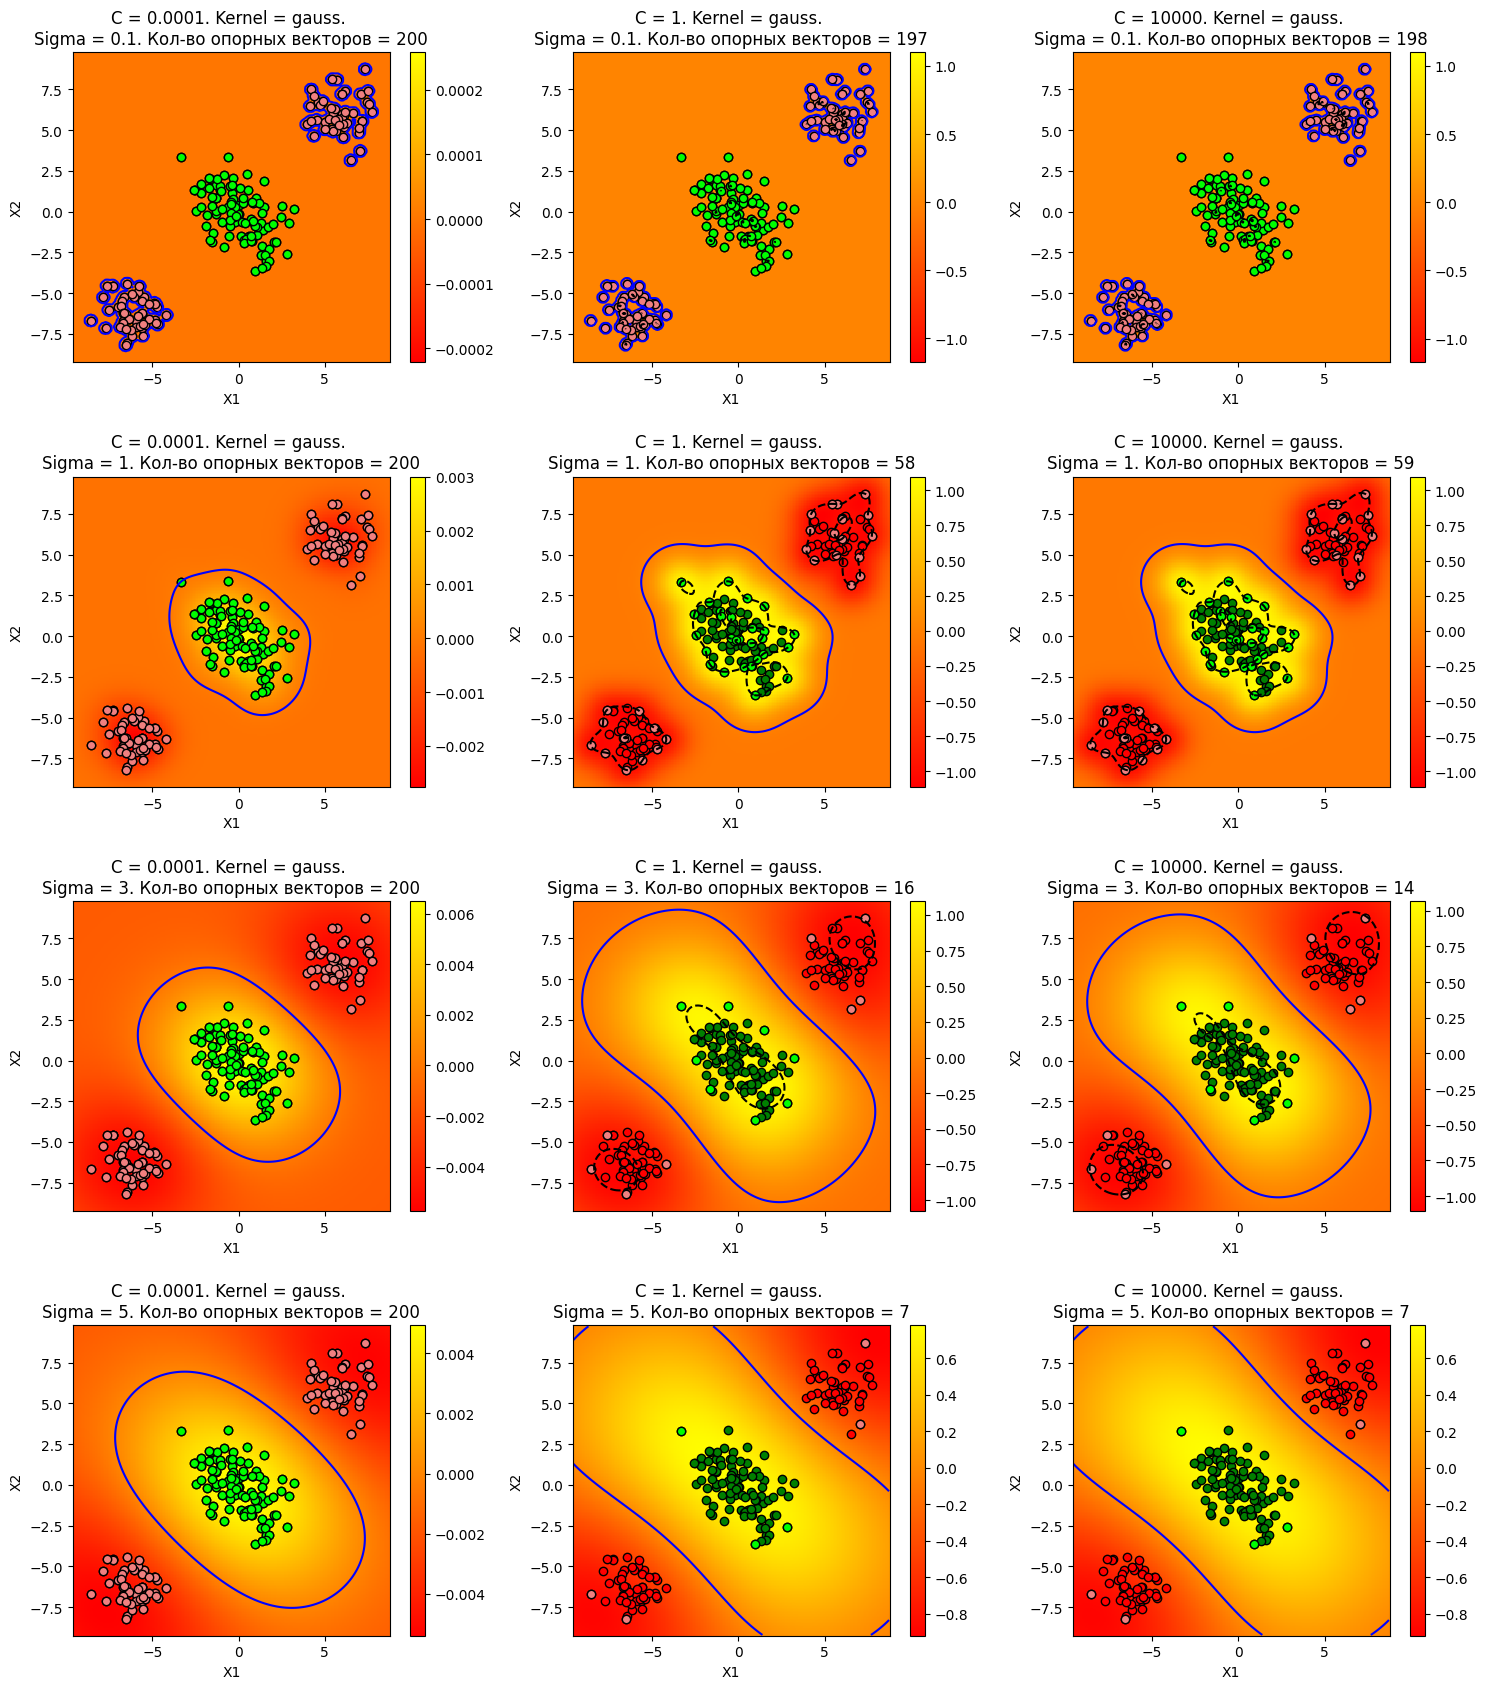

In [25]:
fig, ax = plt.subplots(4, 3, figsize=(15, 17))

C_arr = [0.0001, 1, 10000]
sigma_arr = [0.1, 1, 3, 5]


for i in range(len(sigma_arr)):
    for j in range(len(C_arr)):
        svm = SVM_KERNEL(X=X_notLinear, y=y_notLinear, C=C_arr[j], kernel_function="gauss", sigm=sigma_arr[i])
        svm.fit()
        svm.make_grahp(ax[i][j], fig)

### Если Sigma маленькая, то это будет влиять на переобучение модели, если большая, то к тому что признаки будут описаны плохо

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [ ]:
%pylab inline

## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

In [ ]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [ ]:
np.array([True, False, False]) & np.array([True, False, True])

In [ ]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [ ]:
!pip install --upgrade --user cvxopt

Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [ ]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [ ]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

In [ ]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

In [ ]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

In [ ]:
sol

In [ ]:
print(sol['x'])

Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [ ]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass